In [ ]:
! pip install openpyxl

In [4]:
import os
import pandas as pd
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import openpyxl
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [5]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

import optuna

In [6]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(device)



The code will run on GPU.
cpu


In [7]:
from dataclasses import dataclass

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float
    beta1_disc : float

In [8]:
def init_dataloaders(p):
    workers = 2
    image_size = (64,64)
    #brain tissue
    #dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset'
    #mixed patches
    dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset'
    datasets_train = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1)),
                                ]))

    from torch.utils import data
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
    mri_subset = data.Subset(datasets_train, idx)
    dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=p.bs,
                                            shuffle=True, num_workers=workers)
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
    sos_subset = data.Subset(datasets_train, idx)

    dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=p.bs,
                                            shuffle=True, num_workers=workers)
    return dataloader_mri, dataloader_sos

In [9]:
def init_dataloaders(p):
    workers = 2
    image_size = (64,64)
    #brain tissue
    #dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\train'
    #mixed patches
    dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset\train'
    
    datasets_train = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0, 0, 0), (1, 1, 1)),
                                  ]))

    from torch.utils import data
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
    mri_subset = data.Subset(datasets_train, idx)
    dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=p.bs,
                                             shuffle=True, num_workers=workers)
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
    sos_subset = data.Subset(datasets_train, idx)

    dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=p.bs,
                                             shuffle=True, num_workers=workers)
    return dataloader_mri, dataloader_sos

In [10]:
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

criterion_Im = torch.nn.L1Loss()

In [11]:
def init_models(p):
    G_A2B = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, n_downsampling=p.gen_n_down, padding_type='reflect')
    G_B2A = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect')
    D_A = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)
    D_B = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))

    return G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B

In [12]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, name+"_G_A2B.pt")
  torch.save(G_B2A,  name+"_G_B2A.pt")
  torch.save(D_A,  name+"_D_A.pt")
  torch.save(D_B, name+"_D_B.pt")

def load_models( name):
  G_A2B=torch.load(name+'_G_A2B.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B

In [13]:
def sweep(p,name,j):

    dataloader_mri, dataloader_sos = init_dataloaders(p)

    G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B = init_models(p)
    
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)


    G_losses, D_losses, G_loss_epoch,D_loss_epoch = training(5, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name,j)
    #NEW 15/3/23:
    #for each parameter there will be a list of losses
    #we want to minimize the minimum? or maybe the average of the last 5 values
    print("for parameters ")
    print("batch size = ")
    print(p.bs)
    print("learning rate = ")
    print(p.lr)
    print("the last 5 G losses of each epoch ")
    print(G_loss_epoch)
    print("the last 5 D losses of each epoch")
    print(D_loss_epoch)
    
    #print(G_losses[-5:])
    

    
#     print("Generator loss at the beginning of each epoch ",G_losses[::1653])
#     print("Generator minimal loss ",min(G_losses), "iteration ",G_losses.index(min(G_losses)))




In [14]:
##no grad accumulation
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name,j):
    
    iters=0
    G_losses = []
    D_losses = []
    
    G_loss_epoch = []
    D_loss_epoch = []

    
    
    print('Starting training loop')
    # For each epoch
    for epoch in range(epochs):

        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
            temp_D_losses = 0
            # print(b)
            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
            
            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)
            # print("fake image generated")
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                temp_D_losses += Disc_loss_A

            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
            optimizer_D_A.step()

            
            # Discriminator B

            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B

            Disc_loss_B.backward()
            optimizer_D_B.step()   
            
            D_losses.append(temp_D_losses) # different
            # Generator
            

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()


            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)

            wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
            })

            # Backward propagation
            Loss_G.backward()
            
            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del a_real, b_real, a_fake, b_fake


            #if iters % 50 == 0:
                #print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      #% (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                         #Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
                #print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      #% (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,"final_"+str(j)+name+str(epoch))
        iters = 0 

        for i in range(5,0,-1):
            G_loss_epoch.append(float(G_losses[-i]))
            D_loss_epoch.append(float(D_losses[-i]))
            


    
        
    return G_losses, D_losses, G_loss_epoch,D_loss_epoch

In [ ]:
for i in range(5,0,-1):
    print(i)


In [ ]:
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name):
    
    iters=0
    G_losses = []
    D_losses = []
    optimizer_D_B.zero_grad()
    optimizer_D_A.zero_grad()
    optimizer_G_A2B.zero_grad()
    optimizer_G_B2A.zero_grad()
 
    
    print('Starting training loop')
    # For each epoch
    
    for epoch in range(epochs):
        accumulation_steps = 10
        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):

            temp_D_losses = 0 

            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1)
            

            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)

            #print("fake image generated")
            a_rec = G_B2A(b_fake)

            
            a_fake = G_B2A(b_real)

            b_rec = G_A2B(a_fake)


            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            #optimizer_D_A.zero_grad()


            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)

                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A/accumulation_steps


            else:

  
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                                      
                temp_D_losses += Disc_loss_A/accumulation_steps



            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
                
            #optimizer_D_A.step()

            
            # Discriminator B

            #optimizer_D_B.zero_grad()

            if((iters > 0 or epoch > 0) and iters % 3 == 0):

                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B/accumulation_steps
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B/accumulation_steps

            Disc_loss_B.backward()
            
            if(i+1) % accumulation_steps == 0:
                optimizer_D_A.step()
                
                optimizer_D_A.zero_grad()
                
                optimizer_D_B.step() 
                optimizer_D_B.zero_grad()
            
            #optimizer_D_B.step()   
            
            D_losses.append(temp_D_losses) # different
            # Generator
            

            #optimizer_G_A2B.zero_grad()
            #optimizer_G_B2A.zero_grad()

        
            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G =(Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B)/accumulation_steps
            G_losses.append(Loss_G)


            # Backward propagation
            Loss_G.backward()
            
            if (i+1) % accumulation_steps ==0:

                optimizer_G_A2B.step()
                optimizer_G_B2A.step()
                optimizer_G_A2B.zero_grad()
                optimizer_G_B2A.zero_grad()
                

                
                wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
                })
                

            
            # Optimisation step
            #optimizer_G_A2B.step()
            #optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                #print('running first if')
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()


            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                #print('running second if')
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()


            elif(old_b_fake.shape[0]< 25):
                #print('running 3rd if')
            
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                                       
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))
                


            iters += 1
            del a_real, b_real, a_fake, b_fake



            if iters % 50 == 0:
            
                print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                            % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                                Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
                # print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                #             % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,name)
        iters = 0   
    return G_losses, D_losses


In [12]:
import wandb
#!wandb login 2511293b7c38a80081cadf8f2737b2f6fa992e70
wandb.init(project="mri2sos", entity="powerr")
name = ["bs8","bs64","bs128"]
#name = ["bs1_5","bs2_5","bs4_5","bs8_5","bs16_5", "bs32_5", "bs64_5", "bs128_5"]
ps = []
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.001, beta1=0.9,beta1_disc=0.6))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=0, dis_n_down=4, lr=0.001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=4, lr=0.001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=0, gen_n_blocks=9, dis_n_down=4, lr=0.001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=18, dis_n_down=4, lr=0.001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=128, ndf=64, size=64, gen_n_down=1, gen_n_blocks=8, dis_n_down=1, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.001, beta1=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=6, dis_n_down=2, lr=0.002, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=4, gen_n_blocks=6, dis_n_down=4, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=16, size=64, gen_n_down=4, gen_n_blocks=1, dis_n_down=4, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=32, ndf=64, size=64, gen_n_down=1, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.6))


##ella
#ps.append(Parameters(bs=8, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=1, beta1=0.6, beta1_disc=0.9)) 

ps.append(Parameters(bs=8, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
ps.append(Parameters(bs=64, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
ps.append(Parameters(bs=128, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))


for j in range(3):
    for i in range(len(ps)):
        p = ps[i]
        wandb.init(project="mri2sos", entity="powerr", name=name[i],config = {
            "ngf" : p.ngf,
            "ndf" : p.ndf,
            "gen_n_down" : p.gen_n_down,
            "gen_n_blocks" : p.gen_n_blocks,
            "dis_n_down" : p.dis_n_down,
            "lr" : p.lr,
            "beta1" : p.beta1,
            "beta1_disc" : p.beta1_disc
        })



        sweep(p,name[i],j)
    
    
## grid of parameters
## for each parameter change run sweep(parameter_list, name)
   

wandb: Currently logged in as: ioanalzr (powerr). Use `wandb login --relogin` to force relogin


Starting training loop
for parameters 
batch size = 
8
learning rate = 
0.0001
the last 5 G losses of each epoch 
[1.5523282289505005, 1.520700216293335, 1.3529844284057617, 1.53920316696167, 1.4914125204086304, 1.8380224704742432, 1.767593264579773, 2.2054805755615234, 2.2234983444213867, 1.821817398071289, 1.2852776050567627, 1.809337854385376, 1.785372018814087, 1.5909355878829956, 1.943450689315796, 1.6919573545455933, 1.8671627044677734, 1.586397409439087, 1.724812626838684, 2.1554605960845947, 1.4331507682800293, 1.4113227128982544, 1.299805998802185, 1.4161896705627441, 1.6183875799179077]
the last 5 D losses of each epoch
[0.9498396515846252, 0.9293946027755737, 0.45554354786872864, 0.9957340955734253, 1.0049560070037842, 0.6325556039810181, 0.6975645422935486, 0.2524823248386383, 0.5401273965835571, 0.6193538308143616, 1.0559656620025635, 0.9269905686378479, 0.21606022119522095, 0.8673164248466492, 0.9088153839111328, 0.8475426435470581, 0.8222910165786743, 0.24331820011138916

total_d,▆█▃▇▂▇▃█▄▇▆▇▇▂▄▁▃▁▅▁▃▁▅▆▅▄▂▅▂▆▁▄▂▄▁▅▅▇▇▂
total_g,█▄▃▃▃▂▂▁▂▂▂▃▁▃▃▄▄▃▂▁▃▃▃▂▄▂▂▂▂▃▃▃▁▂▁▃▂▂▁▁
total_d,0.81642
total_g,1.61839


Starting training loop
for parameters 
batch size = 
64
learning rate = 
0.0001
the last 5 G losses of each epoch 
[2.571476936340332, 2.423703670501709, 2.328522205352783, 2.192152261734009, 2.155087471008301, 1.6815338134765625, 1.649719476699829, 1.8172597885131836, 1.6607354879379272, 1.6975548267364502, 1.565286636352539, 1.510616421699524, 1.5795055627822876, 1.548410415649414, 1.4872539043426514, 1.4733119010925293, 1.4944772720336914, 1.4146674871444702, 1.387458086013794, 1.3779041767120361, 1.3343859910964966, 1.3153916597366333, 1.3879528045654297, 1.3179208040237427, 1.3787282705307007]
the last 5 D losses of each epoch
[0.828098475933075, 1.0975620746612549, 1.143776297569275, 0.59713214635849, 1.1522823572158813, 0.4818018674850464, 1.0594249963760376, 1.0584681034088135, 0.4690541625022888, 1.0273470878601074, 0.46068859100341797, 0.986642062664032, 1.0137839317321777, 0.4582744240760803, 0.9973965883255005, 0.4173056483268738, 0.9902573227882385, 1.022713541984558, 0.38

total_d,█▄█▂▆▅▅▅▅▁▅▅▄▄▄▄▄▁▄▄▄▄▁▄▄▄▄▄▄▄▁▄▄▄▄▄▁▄▁▄
total_g,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_d,0.9621
total_g,1.37873


Starting training loop
for parameters 
batch size = 
128
learning rate = 
0.0001
the last 5 G losses of each epoch 
[4.11463737487793, 3.8469736576080322, 3.7088005542755127, 3.6095573902130127, 3.4439802169799805, 2.687373161315918, 2.488110303878784, 2.4568417072296143, 2.312390089035034, 2.2346508502960205, 1.890291452407837, 1.8890774250030518, 1.8698976039886475, 1.9520349502563477, 1.9085204601287842, 1.6791032552719116, 1.731906533241272, 1.6824599504470825, 1.723304033279419, 1.711576223373413, 1.6111390590667725, 1.6187610626220703, 1.6432287693023682, 1.6280956268310547, 1.588283658027649]
the last 5 D losses of each epoch
[1.384967565536499, 0.518630862236023, 1.4292991161346436, 1.4287289381027222, 0.4811849892139435, 1.1404824256896973, 0.7824277877807617, 1.1765397787094116, 1.1745964288711548, 0.5826777219772339, 1.1864023208618164, 0.4655678868293762, 1.1196507215499878, 1.11881685256958, 0.5475149154663086, 1.0737595558166504, 0.47808176279067993, 1.057618260383606, 1.

total_d,█▅▂▃▂▄▁▄▂▄▂▄▂▃▂▃▁▃▁▄▁▃▃▃▂▃▁▃▁▃▃▃▁▃▁▃▃▃▃▁
total_g,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_d,0.46059
total_g,1.58828


Starting training loop
for parameters 
batch size = 
8
learning rate = 
0.0001
the last 5 G losses of each epoch 
[1.6704108715057373, 1.5183384418487549, 1.578391432762146, 1.4580824375152588, 1.5616365671157837, 1.402097463607788, 1.657387375831604, 1.6658985614776611, 1.5080304145812988, 1.6768171787261963, 1.3755931854248047, 1.4569334983825684, 1.5973012447357178, 1.4673810005187988, 1.5557574033737183, 2.2975621223449707, 1.452139973640442, 1.8328487873077393, 1.8767263889312744, 1.7578206062316895, 1.5718563795089722, 1.4403778314590454, 1.3339375257492065, 1.45573890209198, 1.8887648582458496]
the last 5 D losses of each epoch
[0.9753822088241577, 0.9756984710693359, 0.3741249144077301, 0.998670756816864, 0.9226917028427124, 0.837841272354126, 0.976316511631012, 0.2849825918674469, 1.031511664390564, 0.8624321818351746, 0.9139779210090637, 0.9367057681083679, 0.34914925694465637, 0.9717369675636292, 0.9997252225875854, 0.37965112924575806, 0.7359591722488403, 0.2202717810869217

total_d,▆█▅▇▃█▃█▄██▇▇▃█▂▇▃▇▂▇▂▇█▇▇▃▅▁▅▁▄▂▅▂▅▅▄▆▂
total_g,█▃▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▃▂▃▂▁▂▄▂▃▃▃▃▂▂
total_d,0.90796
total_g,1.88876


Starting training loop
for parameters 
batch size = 
64
learning rate = 
0.0001
the last 5 G losses of each epoch 
[2.499380111694336, 2.397181272506714, 2.340823173522949, 2.2104344367980957, 2.144428253173828, 1.8273704051971436, 1.6725757122039795, 1.800756573677063, 1.7227461338043213, 1.6808170080184937, 1.550391435623169, 1.5277678966522217, 1.5883629322052002, 1.5246038436889648, 1.5500767230987549, 1.4478341341018677, 1.387141466140747, 1.4865010976791382, 1.5522044897079468, 1.3969173431396484, 1.3453750610351562, 1.3428884744644165, 1.3675479888916016, 1.334691047668457, 1.3387500047683716]
the last 5 D losses of each epoch
[0.833713173866272, 1.1235171556472778, 1.144432783126831, 0.5965209007263184, 1.1980332136154175, 0.502629280090332, 1.0285511016845703, 1.0320868492126465, 0.48121029138565063, 1.0216675996780396, 0.4258662462234497, 0.9944353103637695, 0.9944124221801758, 0.4543650150299072, 0.9526817798614502, 0.41852983832359314, 0.9994502663612366, 0.9993351101875305

total_d,█▃█▂▅▅▅▄▅▁▄▄▄▄▄▄▄▁▄▄▄▄▁▄▄▄▄▄▄▄▁▄▄▄▄▄▁▄▁▄
total_g,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_d,0.95357
total_g,1.33875


Starting training loop
for parameters 
batch size = 
128
learning rate = 
0.0001
the last 5 G losses of each epoch 
[3.7090961933135986, 3.5104334354400635, 3.3330633640289307, 3.4562454223632812, 3.4637832641601562, 2.401062488555908, 2.254951000213623, 2.1482884883880615, 2.075230836868286, 1.9770448207855225, 1.8733959197998047, 1.8691959381103516, 1.8569221496582031, 1.9406530857086182, 1.8973275423049927, 1.681593418121338, 1.6307060718536377, 1.6611229181289673, 1.7482240200042725, 1.6878587007522583, 1.621825098991394, 1.6264069080352783, 1.6498329639434814, 1.6553027629852295, 1.612342119216919]
the last 5 D losses of each epoch
[1.3945955038070679, 0.5718966722488403, 1.400602102279663, 1.4710731506347656, 0.6290606260299683, 1.155536413192749, 0.6624007821083069, 1.1790587902069092, 1.1787197589874268, 0.5071608424186707, 1.1180760860443115, 0.5218573808670044, 1.072157621383667, 1.0781679153442383, 0.5936595797538757, 1.083428144454956, 0.4210585951805115, 1.0675616264343262

total_d,█▅▂▃▂▄▂▄▂▄▂▄▂▃▂▃▁▄▁▄▁▃▃▃▂▃▁▃▁▃▃▃▁▃▁▃▃▃▃▁
total_g,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_d,0.48457
total_g,1.61234


Starting training loop
for parameters 
batch size = 
8
learning rate = 
0.0001
the last 5 G losses of each epoch 
[1.5979347229003906, 1.3362178802490234, 1.585881233215332, 1.4956228733062744, 1.476692795753479, 1.4872912168502808, 1.6024750471115112, 1.5114026069641113, 1.2740479707717896, 1.459072470664978, 1.3064155578613281, 1.3969731330871582, 1.3300793170928955, 1.3884421586990356, 1.3684303760528564, 1.6804835796356201, 2.088522434234619, 1.9970816373825073, 1.8252885341644287, 2.200604200363159, 1.3486919403076172, 1.496081829071045, 1.328649878501892, 1.4364039897918701, 1.7225021123886108]
the last 5 D losses of each epoch
[0.9472051858901978, 1.1694320440292358, 0.4278649091720581, 0.930793285369873, 0.9310033321380615, 0.8397694826126099, 0.8447607755661011, 0.37136733531951904, 0.8953092694282532, 0.9747006297111511, 0.932161271572113, 0.8545761108398438, 0.3688916563987732, 0.8132877349853516, 0.8572057485580444, 0.9280993938446045, 0.6030903458595276, 0.3412982225418091

total_d,▆▇▄▆▃▇▂█▃▇▇▇▇▃▆▂▇▃▇▂▆▃▆▆▆▆▂▄▁▄▁▅▂▅▂▆▅▄▅▂
total_g,█▅▄▄▄▅▃▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▂▂▂▂▄▃▂▄▃▃▂▂▂▃▂▃▂▁
total_d,0.957
total_g,1.7225


Starting training loop
for parameters 
batch size = 
64
learning rate = 
0.0001
the last 5 G losses of each epoch 
[2.3550102710723877, 2.225795269012451, 2.2036080360412598, 2.0683748722076416, 2.0958333015441895, 1.6976335048675537, 1.668666958808899, 1.778120994567871, 1.7081564664840698, 1.6768269538879395, 1.5298348665237427, 1.5834678411483765, 1.510780930519104, 1.5090420246124268, 1.5856842994689941, 1.4369361400604248, 1.4695584774017334, 1.5833840370178223, 1.4180371761322021, 1.4122563600540161, 1.3955074548721313, 1.3685102462768555, 1.4557256698608398, 1.4902756214141846, 1.5551655292510986]
the last 5 D losses of each epoch
[0.6620829105377197, 1.1527893543243408, 1.1882836818695068, 0.49722445011138916, 1.2083003520965576, 0.4821609854698181, 1.0490753650665283, 1.03651762008667, 0.46274682879447937, 1.0576467514038086, 0.447004497051239, 0.9750097990036011, 1.001375436782837, 0.39152052998542786, 1.028383731842041, 0.42222392559051514, 0.945986270904541, 0.9181445240974

total_d,█▄█▂▇▆▆▆▆▁▆▅▆▅▅▅▅▁▅▅▅▅▁▅▅▅▅▅▅▅▁▄▅▅▅▅▁▅▁▅
total_g,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_d,0.95559
total_g,1.55517


Starting training loop
for parameters 
batch size = 
128
learning rate = 
0.0001
the last 5 G losses of each epoch 
[4.985354900360107, 4.402529716491699, 3.994819164276123, 3.8195013999938965, 3.6454951763153076, 2.702784538269043, 2.5482397079467773, 2.460190773010254, 2.415588855743408, 2.2828755378723145, 1.94883394241333, 1.9402503967285156, 1.946685791015625, 1.918431282043457, 1.9292752742767334, 1.784379005432129, 1.735791802406311, 1.7589155435562134, 1.788989782333374, 1.7278501987457275, 1.676812767982483, 1.6162469387054443, 1.6768245697021484, 1.6987786293029785, 1.6499924659729004]
the last 5 D losses of each epoch
[1.126334309577942, 0.4898970127105713, 1.046079397201538, 1.0620207786560059, 0.5209765434265137, 1.2251646518707275, 0.6995965242385864, 1.218999981880188, 1.2020385265350342, 0.6195168495178223, 1.1377990245819092, 0.4644544720649719, 1.110316276550293, 1.0578091144561768, 0.47902315855026245, 1.0407005548477173, 0.4456788897514343, 1.0066895484924316, 1.028

In [15]:
#name = ["bs2_10_2"]
name = ["finaL_bs14","final_bs644","final_bs1284"]
ps = [1,2,3,4,5]
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9, beta1_disc=0.9))
#ps.append(Parameters(bs=2, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9, beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9, beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=128, ndf=16, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2, lr=0.0002, beta1=0.5, beta1_disc=0.5))
#ps.append(Parameters(bs=1, n_channels=1, ngf=128, ndf=16, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2, lr=0.0002, beta1=0.5, beta1_disc=0.5))
##ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.6, beta1_disc=0.9))
##ps.append(Parameters(bs=2, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.6, beta1_disc=0.9))
##ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.6, beta1_disc=0.9))

In [16]:
path = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\mri2sos_dataset\train'
#path = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset\test'
dataset_mri = torch.load(path+'\mri_dataset.pt')
dataset_sos = torch.load(path+'\sos_dataset.pt')
print(len(dataset_mri))
test_mris = dataset_mri[:50][:,:,:,0]
test_soss = dataset_sos[:50][:,:,:,0]

1653


finaL_bs14


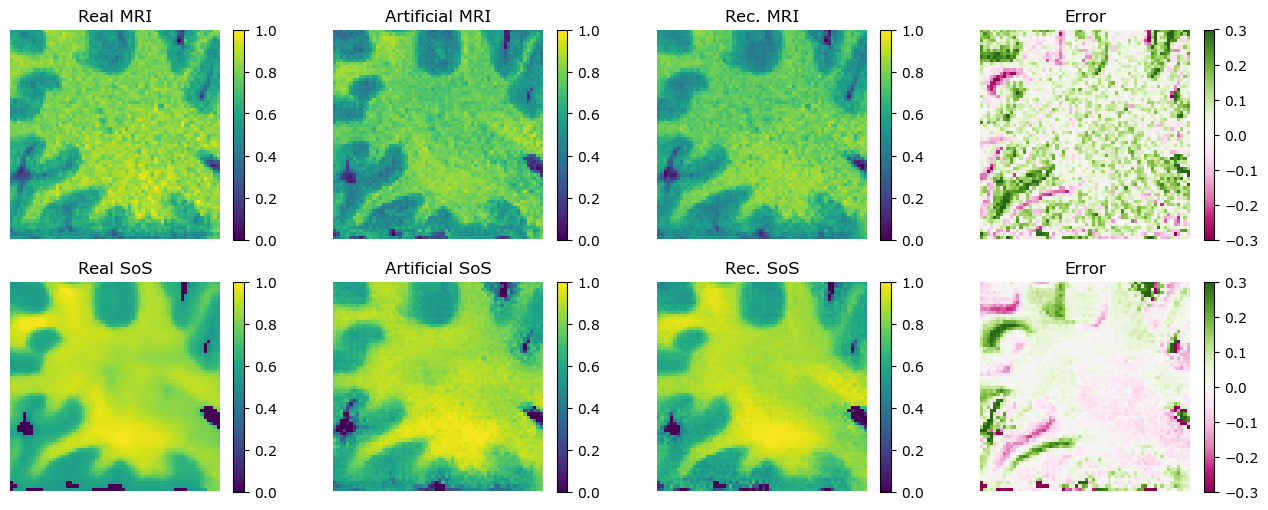

final_bs644


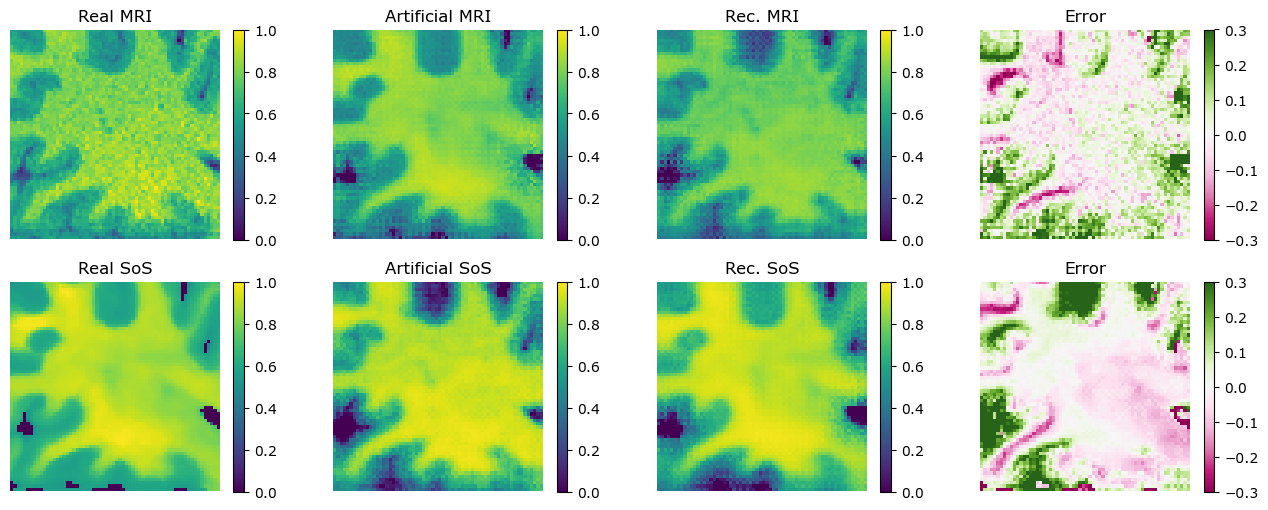

final_bs1284


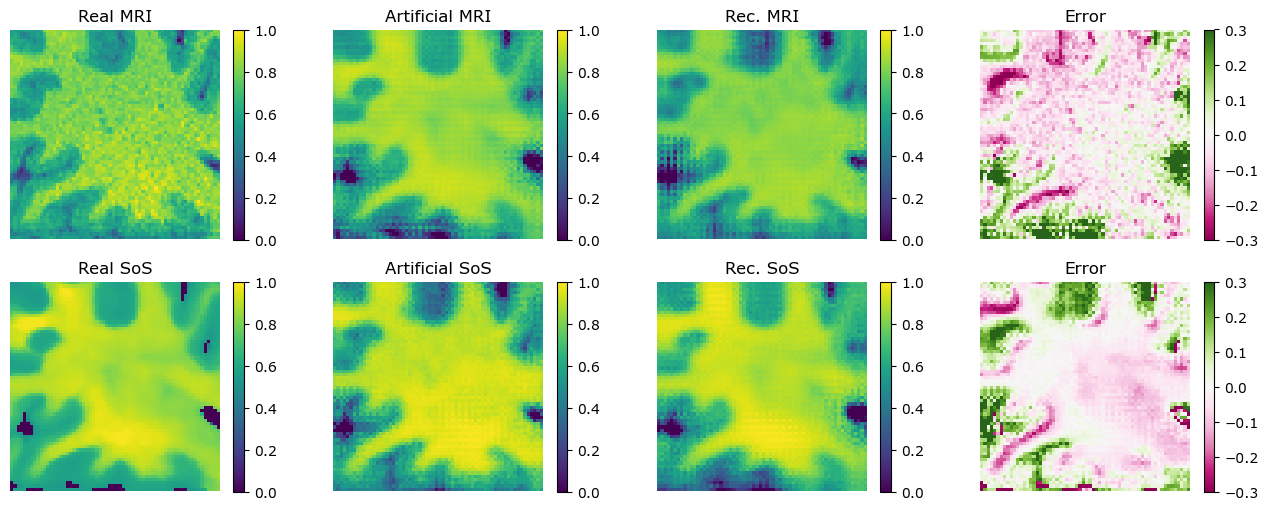

IndexError: list index out of range

In [17]:
for s in range(len(ps)):
    test_fake_mris = []
    test_fake_soss = []
    test_rec_mris = []
    test_rec_soss = []
    G_A2B, G_B2A, D_A, D_B=load_models(name[s])
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)
    for i in range(len(test_mris)):
        real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
        fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
        rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

        real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
        fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
        rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

        test_fake_mris.append(fake_mri)
        test_fake_soss.append(fake_sos)
        test_rec_mris.append(rec_mri)
        test_rec_soss.append(rec_sos)

        with torch.no_grad():
            real_mri.detach().cpu()
            real_sos.detach().cpu()
    n=3
    print(name[s])
    plt.subplots(2,4,figsize=(16,6));
    plt.subplot(2,4,1);plt.imshow(test_mris[n]); plt.title('Real MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,2);plt.imshow(test_fake_mris[n][0,0,:,:]); plt.title('Artificial MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,3);plt.imshow(test_rec_mris[n][0,0,:,:]); plt.title('Rec. MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,4);plt.imshow(test_mris[n]-test_fake_mris[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
    plt.subplot(2,4,5);plt.imshow(test_soss[n]); plt.title('Real SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,6);plt.imshow(test_fake_soss[n][0,0,:,:]); plt.title('Artificial SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,7);plt.imshow(test_rec_soss[n][0,0,:,:]); plt.title('Rec. SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,8);plt.imshow(test_soss[n]-test_fake_soss[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
    plt.show()



In [ ]:
n=3
plt.subplots(2,4,figsize=(16,6));
plt.subplot(2,4,1);plt.imshow(test_mris[n]); plt.title('Real MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,2);plt.imshow(test_fake_mris[n][0,0,:,:]); plt.title('Artificial MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,3);plt.imshow(test_rec_mris[n][0,0,:,:]); plt.title('Rec. MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,4);plt.imshow(test_mris[n]-test_fake_mris[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
plt.subplot(2,4,5);plt.imshow(test_soss[n]); plt.title('Real SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,6);plt.imshow(test_fake_soss[n][0,0,:,:]); plt.title('Artificial SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,7);plt.imshow(test_rec_soss[n][0,0,:,:]); plt.title('Rec. SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,8);plt.imshow(test_soss[n]-test_fake_soss[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
plt.show()

In [ ]:
p = ps[6]
G_A2B, G_B2A, D_A, D_B=load_models("t1_res18")
G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
dataloader_mri, dataloader_sos = init_dataloaders(p)
optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
wandb.init(project="mri2sos", entity="powerr", name="train_t1_res18",config = {
         "ngf" : p.ngf,
         "ndf" : p.ndf,
         "gen_n_down" : p.gen_n_down,
         "gen_n_blocks" : p.gen_n_blocks,
         "dis_n_down" : p.dis_n_down,
         "lr" : p.lr,
         "beta1" : p.beta1,
         "beta1_disc" : p.beta1_disc
        
         })
G_losses, D_losses = training(5, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name)   

In [ ]:
G_A2B, G_B2A, D_A, D_B=load_models("test_lr-50")
print(G_A2B)
